In [1]:
from random import sample
import json
import base64
import gzip
from io import BytesIO
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from sqlalchemy import select, func
from eyened_orm import (
    ImageInstance,
    Annotation,
    AnnotationData,
    AnnotationType,
    DBManager,
    Segmentation
)
from eyened_orm.utils import get_config
from eyened_orm.utils.zarr.manager_annotation import AnnotationZarrStorageManager
from eyened_orm.Segmentation import Datatype, DataRepresentation

In [2]:
config = get_config("dev")
DBManager.init(config)
session = DBManager.get_session()
annotation_zarr_storage_manager = AnnotationZarrStorageManager(
    config.annotations_zarr_store
)

In [3]:
def get_annotations_with_annotation_type(annotation_type_ids):
    # 
    all_annots = session.execute(
        select(Annotation, AnnotationData, ImageInstance)
        .join_from(Annotation, AnnotationData, isouter=True)
        .join_from(Annotation, ImageInstance, isouter=True)
        .where(~Annotation.Inactive & (Annotation.AnnotationTypeID.in_(annotation_type_ids)))
        .order_by(func.random())
        .limit(5)
    ).all()
    all_annots = [(annot, annot_data, image_instance) for annot, annot_data, image_instance in all_annots if annot_data is not None]
    return all_annots

In [ ]:
# 13 binary mask annotations
# 14 probability annotations
# 20 oct binary mask annotations
# 4 label numbers



def open_data(dpath, db_res=None):
    if dpath.suffix == ".gz":
        assert db_res is not None, "db_res is required for .gz files"
        with gzip.open(dpath, 'rb') as f:
            im = np.frombuffer(f.read(), dtype=np.uint8)
            im = im.reshape(db_res) # HWD
            # transpose to DHW
            im = im.transpose(2,0,1)
    else:
        im = Image.open(dpath)

        # if db_res[:2] != im.size:
            # raise RuntimeError(f'Found shape {im.size} != {db_res} for {dpath}')

        if im.mode != "L":
            print(f"Found mode {im.mode} for {dpath}")
            im = im.convert('L')

        im = np.array(im)
        
    if len(im.shape) == 2:
        im = im[None,...].astype(np.uint8)
    
    if len(im.shape) != 3:
        raise RuntimeError(f'Found shape {im.shape} for {dpath}')

    return im # DHW




def convert_annotations_basic(annotation_type_id):
    elems = get_annotations_with_annotation_type([annotation_type_id])
    annotations = []
    segmentations = []

    for annot, annot_data, image_instance in elems:
        # if annot_data is None
        # assert annot_data.path.suffix == ".png", annot_data.path

        res_db = (image_instance.Rows_y, image_instance.Columns_x, image_instance.NrOfFrames)

        try:
            im = open_data(annot_data.path, res_db)
        except Exception as e:
            print(f'Error opening {annot_data.path}: {e}')
            continue
        
        if len(im.shape) != 3:
            print(f'Found shape {im.shape} for {annot_data.path}')
            continue

        depth, height, width = im.shape
        segmentation = Segmentation(
            Depth=depth,
            Height=height,
            Width=width,
            SparseAxis=0,
            ScanIndices=None,
            ImageProjectionMatrix=None,
            DataRepresentation=DataRepresentation.Binary,
            DataType=Datatype.R8UI,
            ImageInstanceID=image_instance.ImageInstanceID,
            CreatorID=annot.CreatorID,
            FeatureID = annot.FeatureID
        )

        
        session.add(segmentation)
        session.flush([segmentation])

        segmentation.write_data(im)
        
        segmentations.append(segmentation)
        annotations.append(annot)

    session.commit()
    return annotations, segmentations

In [5]:
# d = convert_annotations_basic(13)
# print(d)

In [ ]:
# annotations, segmentations = convert_annotations_basic(14)


array_name: uint8_1_576_768.zarr
array_name: uint8_1_1372_1359.zarr
array_name: uint8_1_1632_2464.zarr
array_name: uint8_1_576_768.zarr
array_name: uint8_1_1080_1620.zarr
476688 675425
506434 495149
591348 343994
540095 784377
581767 527023


In [27]:
annotations, segmentations = convert_annotations_basic(20)

Error opening /mnt/oogergo/eyened/eyened_platform/annotations/1691382/421398_0.binary.gz: Found shape (121, 496, 1536) for /mnt/oogergo/eyened/eyened_platform/annotations/1691382/421398_0.binary.gz
Error opening /mnt/oogergo/eyened/eyened_platform/annotations/choroid/2231566.binary.gz: Found shape (6, 496, 1024) for /mnt/oogergo/eyened/eyened_platform/annotations/choroid/2231566.binary.gz
Error opening /mnt/oogergo/eyened/eyened_platform/annotations/1691375/421434_0.binary.gz: Found shape (121, 496, 1536) for /mnt/oogergo/eyened/eyened_platform/annotations/1691375/421434_0.binary.gz
Error opening /mnt/oogergo/eyened/eyened_platform/annotations/1691374/421530_0.binary.gz: Found shape (121, 496, 1536) for /mnt/oogergo/eyened/eyened_platform/annotations/1691374/421530_0.binary.gz
Error opening /mnt/oogergo/eyened/eyened_platform/annotations/1691334/419025_0.binary.gz: Found shape (49, 496, 512) for /mnt/oogergo/eyened/eyened_platform/annotations/1691334/419025_0.binary.gz


In [21]:
for annot, seg in zip(annotations, segmentations):
    print(annot.AnnotationID, seg.SegmentationID, seg.ImageInstanceID)


476688 35 675425
506434 36 495149
591348 37 343994
540095 38 784377
581767 39 527023


In [25]:
arr3 = segmentations[2].read_data()

array_name: uint8_1_1632_2464.zarr


In [26]:
np.unique(arr3)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  91,  92,
        93,  94,  95,  96,  99, 100, 101, 102, 104, 105, 106, 110, 111,
       112, 113, 114, 116, 117, 119, 123, 125, 126, 130, 131, 133, 138,
       140, 143, 144, 145, 146, 147, 153, 154, 155, 157, 161, 162, 165,
       166, 167, 168, 169, 171, 172, 174, 175, 177], dtype=uint8)

In [9]:
annot = Annotation.by_id(session,591348)

In [12]:
im = Image.open(annot.AnnotationData[0].path)

In [19]:
im2 = open_data(annot.AnnotationData[0].path)

In [20]:
np.unique(im2)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  91,  92,
        93,  94,  95,  96,  99, 100, 101, 102, 104, 105, 106, 110, 111,
       112, 113, 114, 116, 117, 119, 123, 125, 126, 130, 131, 133, 138,
       140, 143, 144, 145, 146, 147, 153, 154, 155, 157, 161, 162, 165,
       166, 167, 168, 169, 171, 172, 174, 175, 177], dtype=uint8)

In [14]:
arr = np.array(im)

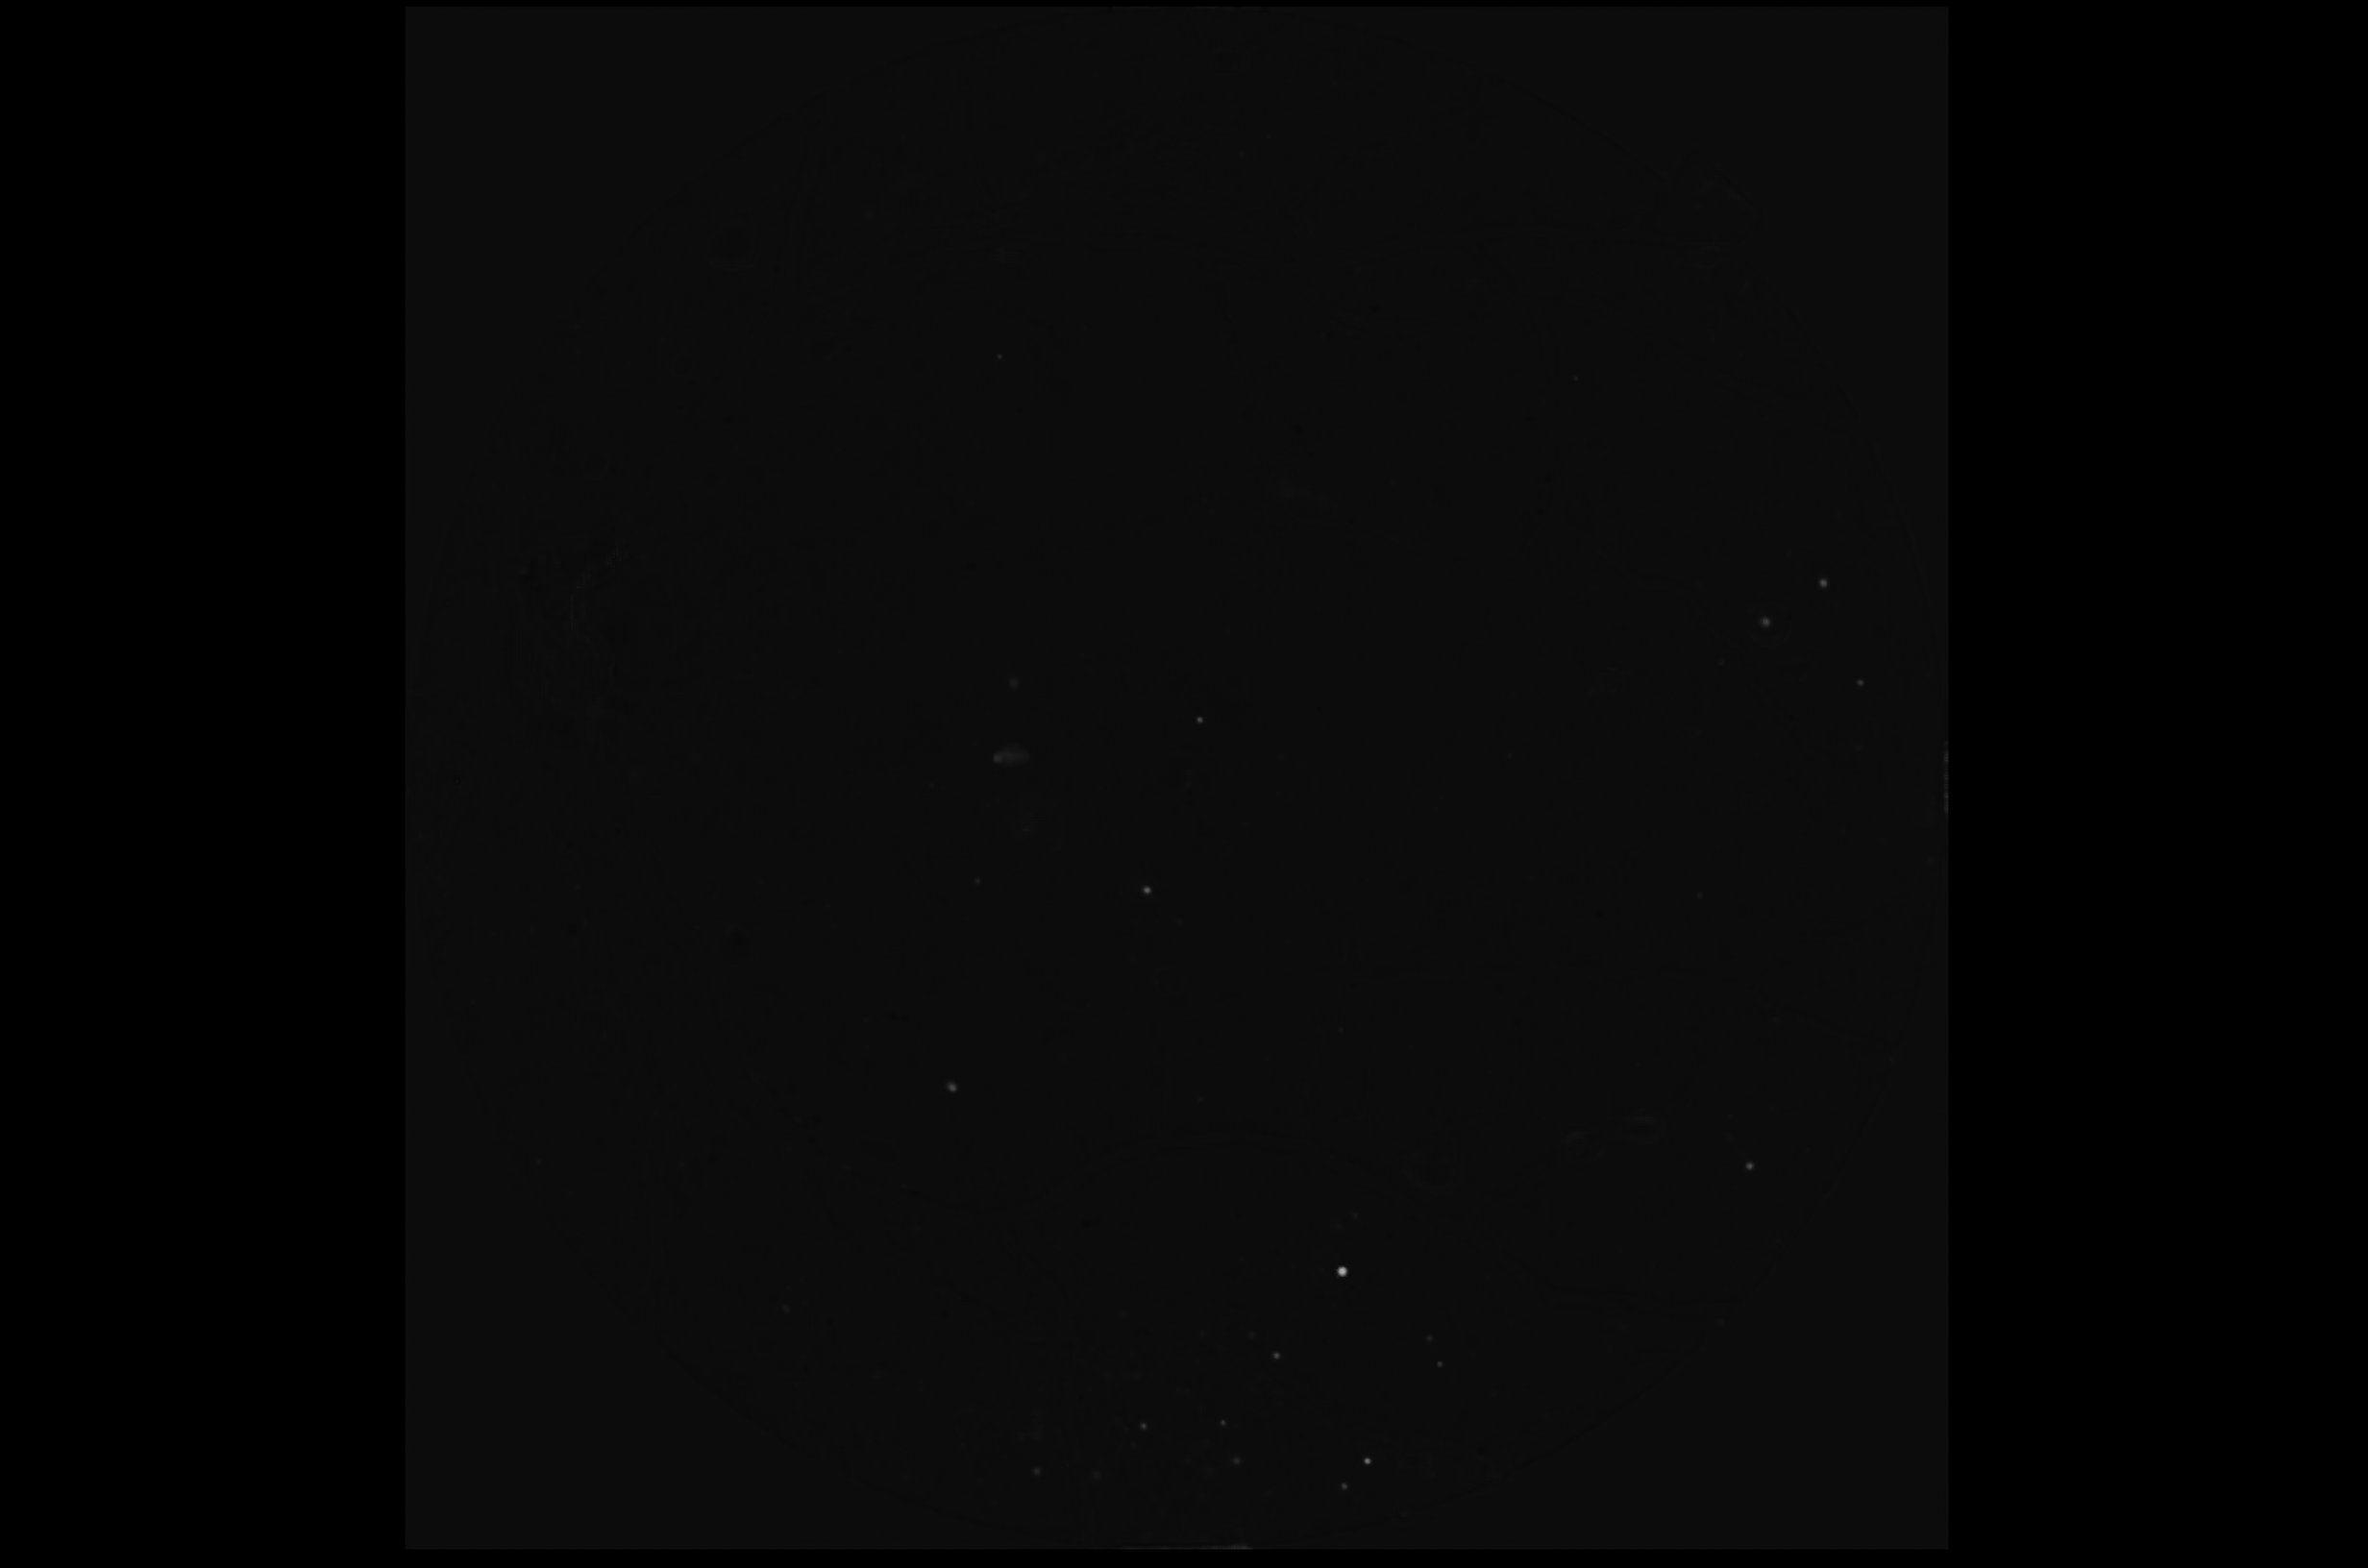

In [16]:
im

In [15]:
np.unique(arr)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  91,  92,
        93,  94,  95,  96,  99, 100, 101, 102, 104, 105, 106, 110, 111,
       112, 113, 114, 116, 117, 119, 123, 125, 126, 130, 131, 133, 138,
       140, 143, 144, 145, 146, 147, 153, 154, 155, 157, 161, 162, 165,
       166, 167, 168, 169, 171, 172, 174, 175, 177], dtype=uint8)

In [18]:
d=open_data('/mnt/oogergo/eyened/eyened_platform/annotations/1691382/421525_0.binary.gz')

In [19]:
d.shape

(92184576,)

In [ ]:


# from matplotlib import pyplot as plt
# # test A/V conversion
# annots = get_annotations_with_annotation_type([9])
# annot = annots[10]
# img_size = (annot[2].Columns_x, annot[2].Rows_y)
# with open(annot[1].path, 'r') as f:
#     data = json.load(f)
# for branch in data['branches']:
#     drawing = branch['drawing'][22:]
#     drawing = base64.b64decode(drawing)
#     # drawing = np.frombuffer(drawing, dtype=np.uint8)
#     drawing = Image.open(BytesIO(drawing))
#     drawing = np.array(drawing)[:, :, 0]
#     drawing = drawing.reshape(img_size[1], img_size[0])
#     plt.imshow(drawing)

In [ ]:
# artery-vein annotations
import json
import base64
resolutions = []
for annot, annot_data, image_instance in get_annotations_with_annotation_type([9]):
    # if annot_data is None
    assert annot_data.path.suffix == ".json", annot_data.path

    if image_instance is None:
        print(f"Found image_instance is None for {annot_data.path}, annot_id: {annot.AnnotationID}")
        continue

    with open(annot_data.path, 'r') as f:
        data = json.load(f)

    mask = Annotation.by_id(session, data['mask_id'])
    if mask is None:
        print(f"Found mask is None for {annot_data.path}, annot_id: {annot.AnnotationID}")
        continue

    img_size = (annot[2].Columns_x, annot[2].Rows_y)
    with open(annot[1].path, 'r') as f:
        data = json.load(f)
    for branch in data['branches']:
        drawing = branch['drawing'][22:]
        drawing = base64.b64decode(drawing)
        # drawing = np.frombuffer(drawing, dtype=np.uint8)
        drawing = Image.open(BytesIO(drawing))
        drawing = np.array(drawing)[:, :, 0]
        drawing = drawing.reshape(img_size[1], img_size[0])

        # put in Zarr
        annot_index = annotation_zarr_storage_manager.write('test', drawing, None)

        # make and link new annotations
        new_annot = Annotation(
            AnnotationTypeID=13,
            ImageInstanceID=image_instance.ImageInstanceID,
            AnnotationReferenceID=mask.AnnotationID,
            # AnnotationDataID=annot_data.AnnotationDataID,
        )

    # res_db = (image_instance.Columns_x, image_instance.Rows_y)
    # resolutions.append(res_db)

    # im = Image.open(annot_data.path)
    # rs_im = im.size

    # if res_db != rs_im:
    #     print(f'Found shape {rs_im} != {res_db} for {annot_data.path}')
    #     continue

    # if im.mode not in ["RGB", "RGBA"]:
    #     print(f"Found mode {im.mode} for {annot_data.path}, annot_id: {annot.AnnotationID}")
    #     im = im.convert('RGB')

    # im = np.array(im)
    # im = im[...,:2] # red and green channels
    # im = im.reshape(1, im.shape[0], im.shape[1], 1, im.shape[2])

Found image_instance is None for /mnt/oogergo/eyened/eyened_platform/annotations/385966/24268_0.json, annot_id: 24268


In [7]:
# R/G masks
resolutions = []
for annot, annot_data, image_instance in get_annotations_with_annotation_type([2,3,5]):
    # if annot_data is None
    assert annot_data.path.suffix == ".png", annot_data.path

    if image_instance is None:
        print(f"Found image_instance is None for {annot_data.path}, annot_id: {annot.AnnotationID}")
        continue

    res_db = (image_instance.Columns_x, image_instance.Rows_y)
    resolutions.append(res_db)

    im = Image.open(annot_data.path)
    rs_im = im.size

    if res_db != rs_im:
        print(f'Found shape {rs_im} != {res_db} for {annot_data.path}')
        continue

    if im.mode not in ["RGB", "RGBA"]:
        print(f"Found mode {im.mode} for {annot_data.path}, annot_id: {annot.AnnotationID}")
        im = im.convert('RGB')

    im = np.array(im)
    im = im[...,:2] # red and green channels
    im = im.reshape(1, im.shape[0], im.shape[1], 1, im.shape[2])
    # im = im[...,None,None].astype(np.uint8)

    # print(im.shape)
    # if len(im.shape) != 4:
    #     print(f'Found shape {im.shape} for {annot_data.path}')
    #     continue

    # annotation_zarr_storage_manager.write('test', im, None)

Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2195243.png, annot_id: 677239
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2217629.png, annot_id: 671653
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2204141.png, annot_id: 668494
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2212353.png, annot_id: 677102
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2225498.png, annot_id: 672951
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula2/2214117.png, annot_id: 173429
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2204055.png, annot_id: 676018
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2188185.png, annot_id: 668926
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/2218258.png, annot_id: 671069
Found mode L for /mnt/oogergo/eyened/eyened_platform/annotations/macula3/